Step 50, Content Loss: 0.6679254174232483, Style Loss: 5.097294888400938e-07, Total Loss: 1.1776549816131592
Step 100, Content Loss: 0.5712186098098755, Style Loss: 4.507270432441146e-07, Total Loss: 1.0219457149505615
Step 150, Content Loss: 0.54414963722229, Style Loss: 4.260313346549083e-07, Total Loss: 0.9701809883117676
Step 200, Content Loss: 0.52817702293396, Style Loss: 4.138129270359059e-07, Total Loss: 0.9419899582862854
Step 250, Content Loss: 0.5184555053710938, Style Loss: 4.063361984663061e-07, Total Loss: 0.924791693687439
Step 300, Content Loss: 0.511913537979126, Style Loss: 4.019954360501288e-07, Total Loss: 0.9139089584350586
Step 350, Content Loss: 0.5079702138900757, Style Loss: 3.988821788425412e-07, Total Loss: 0.9068523645401001
Step 400, Content Loss: 0.5044350624084473, Style Loss: 3.9758023717695323e-07, Total Loss: 0.9020153284072876
Step 450, Content Loss: 0.5019404292106628, Style Loss: 3.9654989336668223e-07, Total Loss: 0.898490309715271
Step 500, Conten

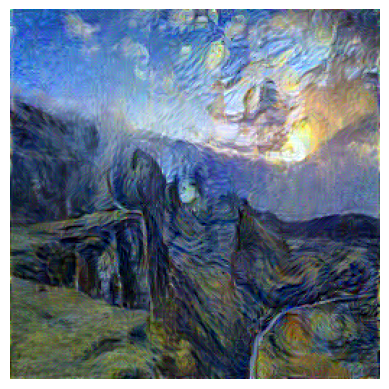

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load VGG19 model
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Define absolute paths
content_path = r"C:\Users\ASUS\Desktop\Codtech-AI-Internship\Task3\content.jpg.jpg"
style_path = r"C:\Users\ASUS\Desktop\Codtech-AI-Internship\Task3\style.jpg.jpg"

# Load content and style images
content_image = Image.open(content_path).convert("RGB")
style_image = Image.open(style_path).convert("RGB")

# Preprocess images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
content_tensor = transform(content_image).unsqueeze(0).to(device)
style_tensor = transform(style_image).unsqueeze(0).to(device)

# Define loss functions
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()
    def gram_matrix(self, input):
        a, b, c, d = input.size()  # a=batch size, b=channels, c=height, d=width
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)
    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

# Function to get features from VGG layers
def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in model.named_children():
        x = layer(x)
        if name in layers:
            features[name] = x
    return features

# Style transfer function
def run_style_transfer(content_img, style_img, num_steps=500):
    """
    Applies style transfer to content image.
    Args:
        content_img (tensor): Content image tensor
        style_img (tensor): Style image tensor
        num_steps (int): Number of optimization steps
    Returns:
        tensor: Styled image
    """
    # Initialize input image with content image plus some noise
    input_img = content_img.clone() + torch.randn_like(content_img) * 0.1
    input_img = input_img.clamp(0, 1).requires_grad_(True)

    # Use LBFGS optimizer with a learning rate
    optimizer = optim.LBFGS([input_img], lr=1.0)

    content_layers = ['21']  # conv4_2 in VGG19 (index 21)
    style_layers = ['0', '5', '10', '19', '28']  # conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
    content_weight = 1.0
    style_weight = 1e6  # Increased to emphasize style

    # Get content and style features
    content_features = get_features(content_img, vgg, content_layers)
    style_features = get_features(style_img, vgg, style_layers)

    # Initialize loss modules
    content_losses = []
    style_losses = []
    for layer in content_layers:
        target = content_features[layer]
        content_loss = ContentLoss(target)
        content_losses.append(content_loss)
    for layer in style_layers:
        target_feature = style_features[layer]
        style_loss = StyleLoss(target_feature)
        style_losses.append(style_loss)

    # Optimization loop
    run = [0]
    while run[0] < num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()

            # Get features of the input image
            input_features = get_features(input_img, vgg, content_layers + style_layers)

            # Compute losses
            content_score = 0
            style_score = 0
            for i, layer in enumerate(content_layers):
                content_losses[i].forward(input_features[layer])
                content_score += content_losses[i].loss
            for i, layer in enumerate(style_layers):
                style_losses[i].forward(input_features[layer])
                style_score += style_losses[i].loss

            # Combine losses
            loss = content_weight * content_score + style_weight * style_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Step {run[0]}, Content Loss: {content_score.item()}, Style Loss: {style_score.item()}, Total Loss: {loss.item()}")
            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

# Run style transfer
output = run_style_transfer(content_tensor, style_tensor)

# Save and display output
output_path = r"C:\Users\ASUS\Desktop\Codtech-AI-Internship\Task3\styled_image.jpg"
output_img = transforms.ToPILImage()(output.squeeze(0).cpu())
output_img.save(output_path)
plt.imshow(output_img)
plt.axis('off')
plt.show()